In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate
from sklearn.model_selection import train_test_split

**TODO**: Change file upload to github upload

In [2]:
from google.colab import files
src = list(files.upload().values())[0]
open('UNet_impl.py','wb').write(src)


Saving UNet_impl.py to UNet_impl.py


1643

In [3]:
import UNet_impl as unet

In [4]:
from google.colab import drive

In [5]:
drive.mount('myDrive')

Mounted at myDrive


In [6]:
#!unzip -uq "/content/myDrive/MyDrive/dataset_AnomalyTrack.zip" -d "/content/myDrive/MyDrive/dataset_AnomalyTrack"

In [7]:
import os
DATASET_PATH = '/content/myDrive/MyDrive/dataset_AnomalyTrack/dataset_AnomalyTrack'
IMAGES_PATH = os.path.join(DATASET_PATH, 'images')
MASKS_PATH = os.path.join(DATASET_PATH, 'labels_masks')
images = []
masks = []
im_filenames = []
for filename in os.listdir(IMAGES_PATH):
    if filename.startswith('validation'):
        im_filenames.append(filename)

In [8]:
im_filenames.sort()

In [9]:
im_filenames

['validation0000.jpg',
 'validation0001.jpg',
 'validation0002.jpg',
 'validation0003.jpg',
 'validation0004.jpg',
 'validation0005.jpg',
 'validation0006.jpg',
 'validation0007.jpg',
 'validation0008.jpg',
 'validation0009.jpg']

In [10]:
for filename in im_filenames:
    FILE_PATH = os.path.join(IMAGES_PATH, filename)
    images.append(plt.imread(FILE_PATH))

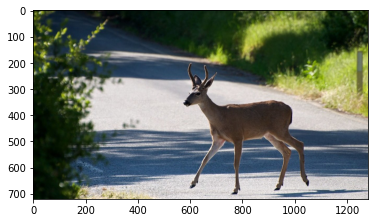

In [11]:
plt.imshow(images[0])

In [12]:
m_filenames = []
for filename in os.listdir(MASKS_PATH):
    if filename.endswith('_color.png'):
        m_filenames.append(filename)

In [13]:
m_filenames.sort()

In [14]:
m_filenames

['validation0000_labels_semantic_color.png',
 'validation0001_labels_semantic_color.png',
 'validation0002_labels_semantic_color.png',
 'validation0003_labels_semantic_color.png',
 'validation0004_labels_semantic_color.png',
 'validation0005_labels_semantic_color.png',
 'validation0006_labels_semantic_color.png',
 'validation0007_labels_semantic_color.png',
 'validation0008_labels_semantic_color.png',
 'validation0009_labels_semantic_color.png']

In [15]:
for filename in m_filenames:
    FILE_PATH = os.path.join(MASKS_PATH, filename)
    masks.append(plt.imread(FILE_PATH))

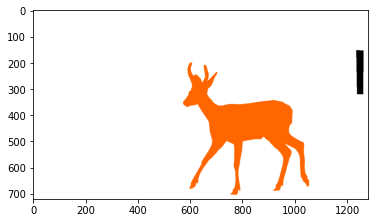

In [16]:
plt.imshow(masks[0])

In [17]:
images[1].shape

(720, 1280, 3)

In [18]:
masks[0].shape

(720, 1280, 3)

Split data to train and test:

In [19]:
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size = 0.3, random_state = 42) 

Normalize:

In [20]:
def normalize_image(image):
  image = tf.cast(image, tf.float32) / 255.0
  image = tf.image.resize(image, (128, 128))
  return image

In [21]:
def resize_mask(mask):
  mask = tf.image.resize(mask, (128, 128))
  return mask

In [22]:
train_images_normalized = []
train_masks_normalized = []
for (x, y) in  zip(train_images, train_masks):
    train_images_normalized.append(normalize_image(x))
    train_masks_normalized.append(resize_mask(y))

In [23]:
def resize_test_data(test_images, test_masks):
    new_img = []
    new_masks = []
    for (x, y) in  zip(test_images, test_masks):
        new_img.append(normalize_image(x))
        new_masks.append(resize_mask(y))
    return new_img, new_masks

In [24]:
test_images, test_masks = resize_test_data(test_images, test_masks)

In [25]:
test_images[1].shape

TensorShape([128, 128, 3])

In [26]:
train_images_normalized[1].shape

TensorShape([128, 128, 3])

In [27]:
train_masks_normalized[0].shape

TensorShape([128, 128, 3])

Show images:

In [28]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

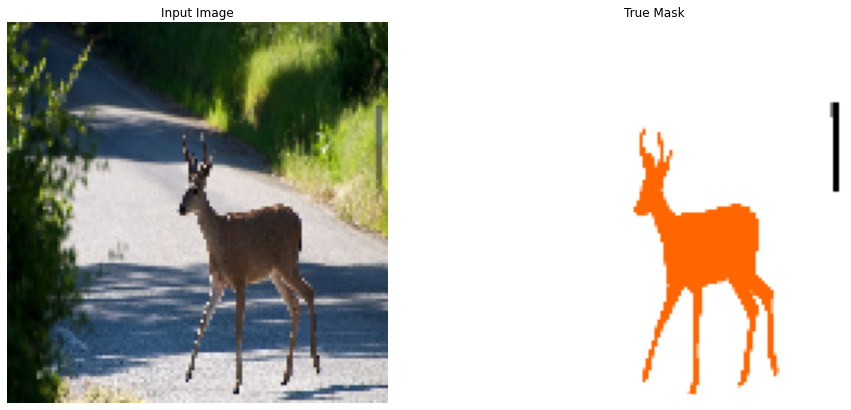

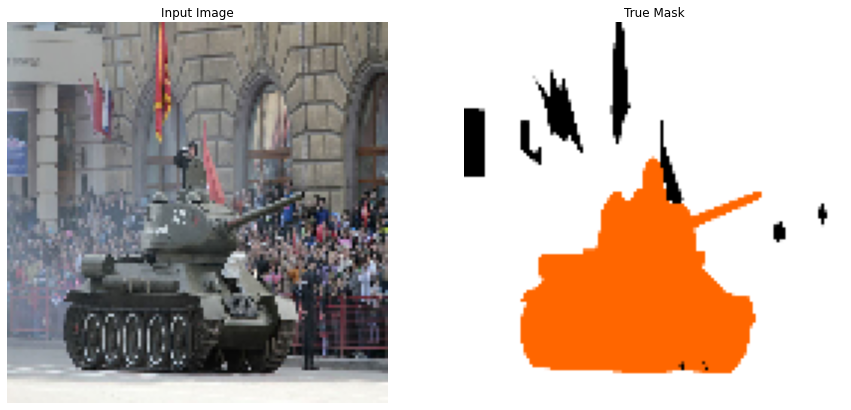

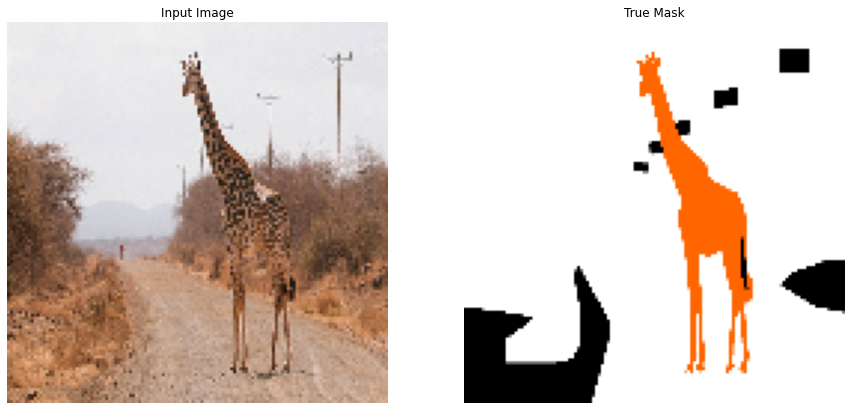

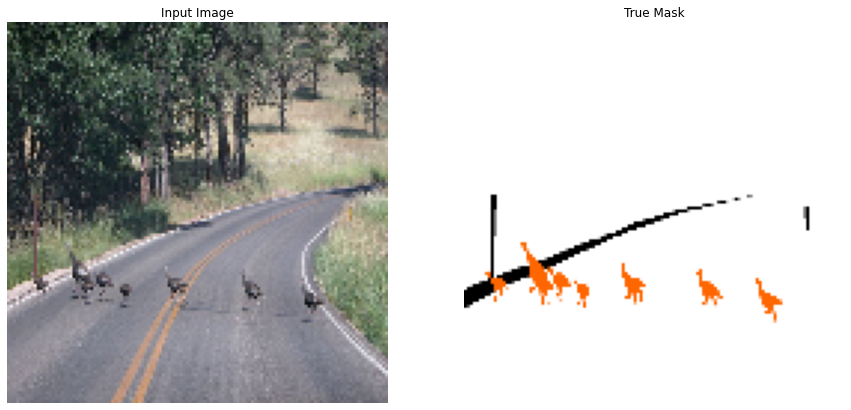

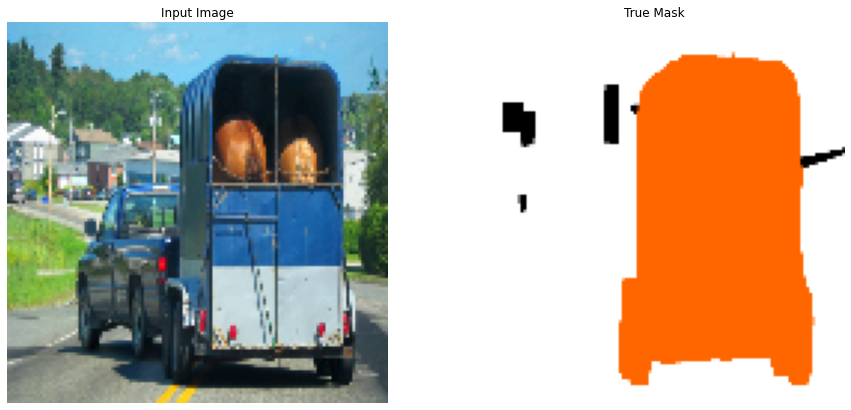

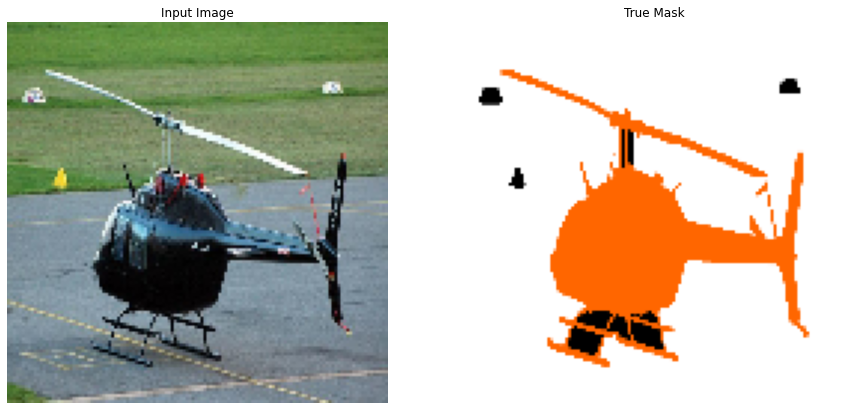

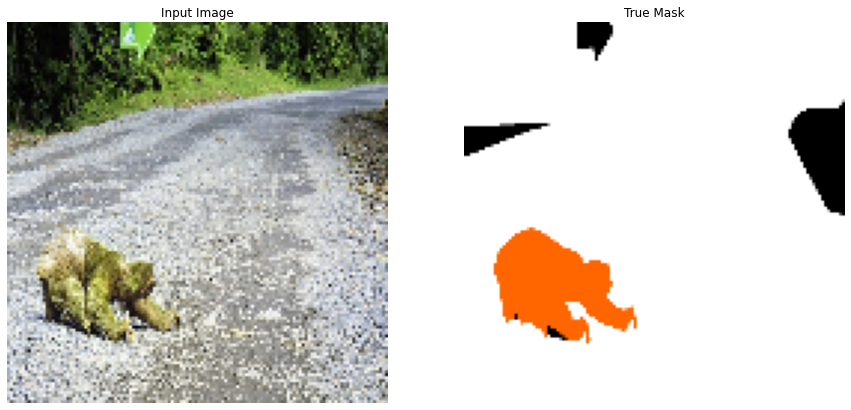

In [29]:
for image, mask in zip(train_images_normalized, train_masks_normalized):
  display([image, mask])

In [30]:
train_images_normalized[0].shape

TensorShape([128, 128, 3])

Compile model:

In [31]:
model = unet.build_unet((128, 128, 3))

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [34]:
train_images_normalized = np.asarray(train_images_normalized)
train_masks_normalized = np.asarray(train_masks_normalized)
test_images = np.asarray(test_images)
test_masks = np.asarray(test_masks)

In [35]:
# for image, mask in zip(test_images, test_masks):
#   display([image, mask])

In [36]:
test_images.shape

(3, 128, 128, 3)

In [37]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [38]:
def show_predictions():
    display([train_images_normalized[0], 
             train_masks_normalized[0],
             create_mask(model.predict(train_images_normalized[0][np.newaxis, ...]))])

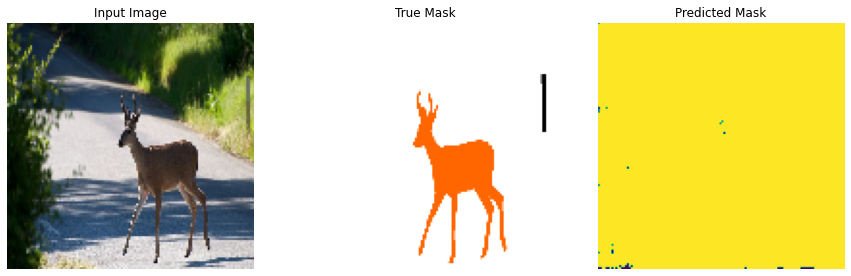

In [39]:
show_predictions()

In [40]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [41]:
type(train_images_normalized)

numpy.ndarray

In [42]:
len(train_images_normalized)

7

In [43]:
TRAIN_LENGTH = len(train_images_normalized)
BATCH_SIZE = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
BUFFER_SIZE = 1000
print(STEPS_PER_EPOCH)

1


In [44]:
x = tf.data.Dataset.from_tensor_slices(train_images_normalized)
y = tf.data.Dataset.from_tensor_slices(train_masks_normalized)

In [45]:
ds = tf.data.Dataset.from_tensor_slices((train_images_normalized, train_masks_normalized))

In [46]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [47]:
train_batches = (
    ds
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = tf.data.Dataset.from_tensor_slices((test_images, test_masks)).batch(BATCH_SIZE)

In [48]:
train_batches.cardinality

<bound method DatasetV2.cardinality of <PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 3)), types: (tf.float32, tf.float32)>>

In [49]:
type(ds)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

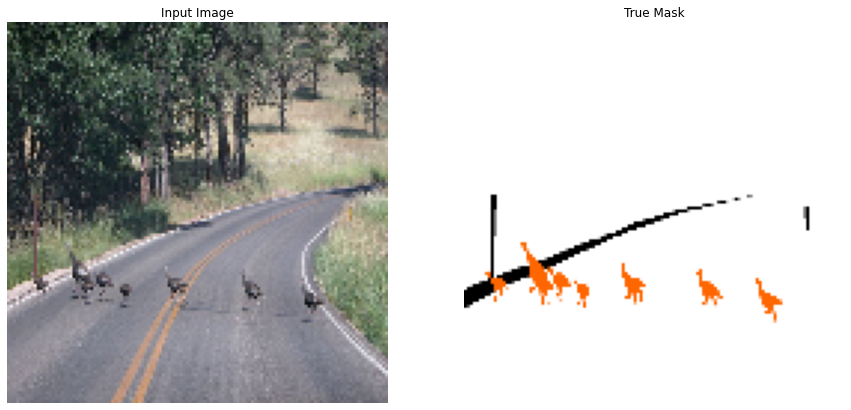

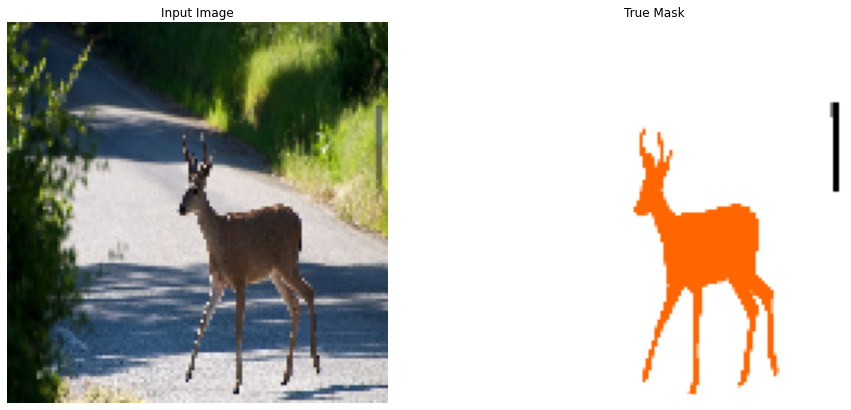

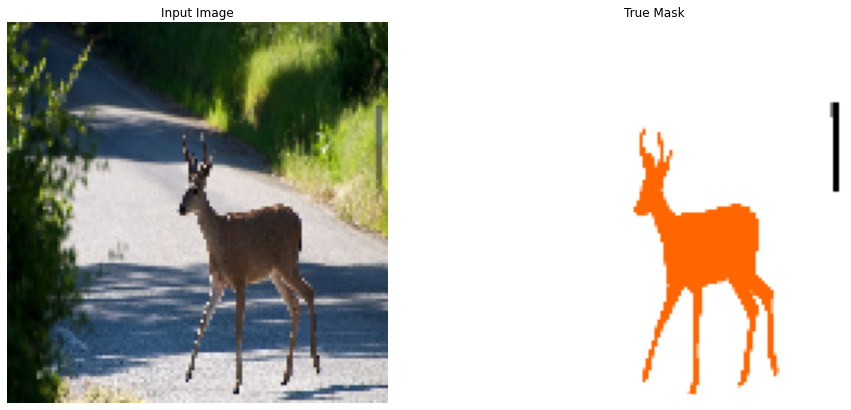

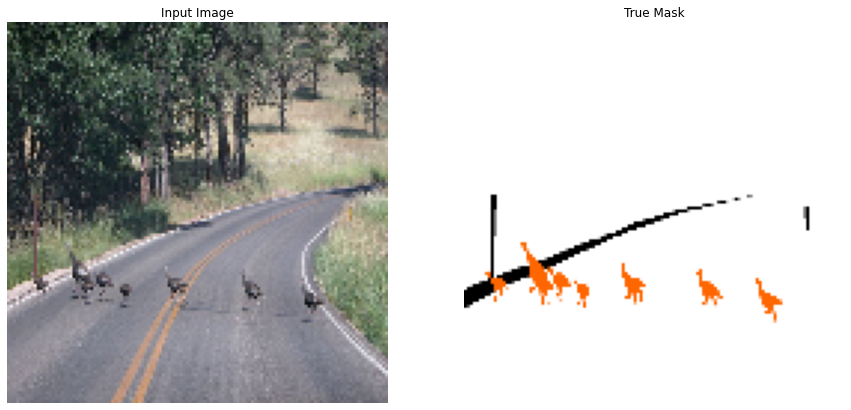

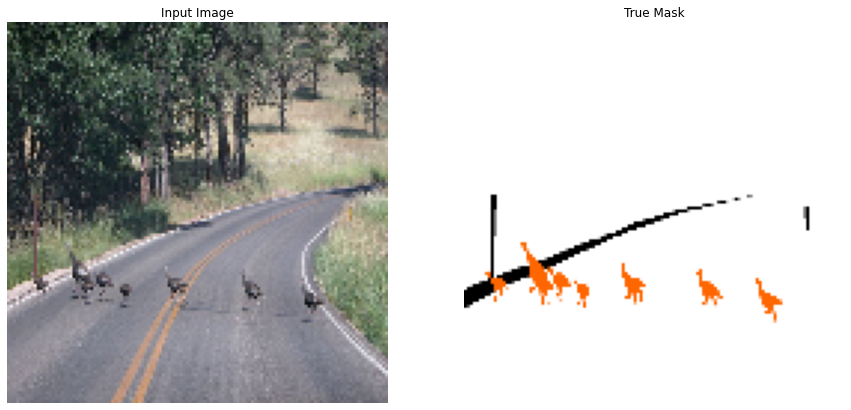

In [50]:
for image, mask in train_batches.take(5):
    display([image[0], mask[0]])

In [51]:
len(test_images)

3

In [52]:
EPOCHS = 10
VALIDATION_STEPS = len(test_images)//BATCH_SIZE//5

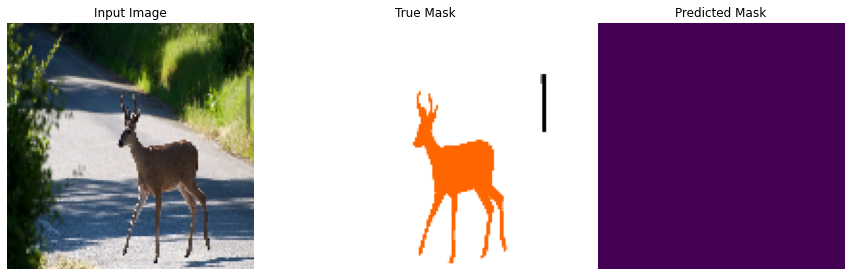


Sample Prediction after epoch 10

2/2 [==============================] - 1s 525ms/step - loss: 27942005544904032256.0000 - accuracy: 0.8273


In [53]:
model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=2,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

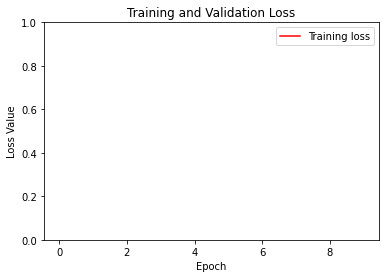

In [54]:
loss = model_history.history['loss']
#val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
#plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

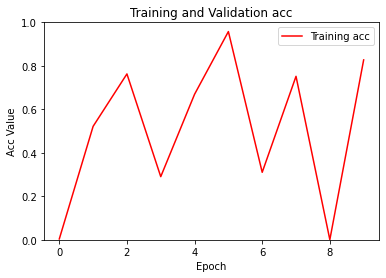

In [55]:
loss = model_history.history['accuracy']
#val_loss = model_history.history['val_accuracy']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training acc')
#plt.plot(model_history.epoch, val_loss, 'bo', label='Validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Acc Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Predictions:

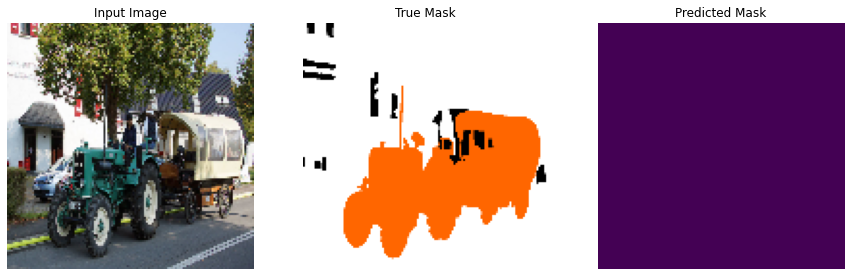

In [56]:
for image, mask in test_batches:
    pred_mask = model.predict(image)
    display([image[0], mask[0], create_mask(pred_mask)])